# Force chains in emulsion gels


## About this notebook
In this notebook we perform the analysis of the experimental data. The data are stored in the `data` folder

In [99]:
ls data

phi_p_0.8/    phi_p_1.5/    phi_p_2.0/    stressTensor/
phi_p_1.2/    phi_p_1.7/    phi_p_2.3/


Each folder contains pure `txt` files with the original data from Jun and `xyz` files that can be rendered in `Ovito` or `VMD`.

In [100]:
ls data/phi_p_0.8/

Contact_center.txt   contacts.xyz         particle_center.txt
TCC/                 coords.xyz
box.txt              inputparameters.ini


Lengthy and complex algorithms should be stored in the folder `src`

In [101]:
ls src

__pycache__/           geometry.py            merge_coord_stress.py
convert_txt2xyz.py     io.py


## Visualising the data

We first import the basic numerical and visuaisation modules. If they are missing, thhey can be install via `pip install module-name`. For example 

`pip install ipyvolume`

In [191]:
import numpy as np
import scipy as sp
import ipyvolume as ipv
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [334]:
%load_ext autoreload
%autoreload 2
from src import io

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [335]:
pol = 1.2
centres = io.Centres(f"data/phi_p_{pol}/coords.xyz")
contacts = io.Contacts(f"data/phi_p_{pol}/contacts.xyz")

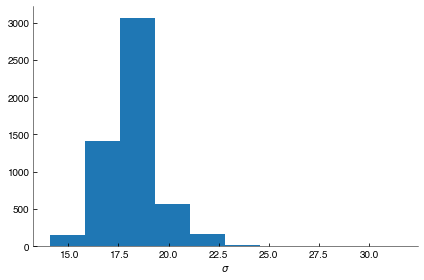

In [105]:
plt.hist(2*centres.radius); plt.xlabel('$\sigma$');

In [106]:
x, y, z = centres.unpack()
color = np.array([(x-x.min())/x.ptp(),np.ones_like(x), np.ones_like(x)]).T
ipv.scatter(x, y, z, size=centres.radius/2.5, marker="sphere", color=color)

x, y, z = contacts.unpack()
ipv.scatter(x, y, z, size=0.9, marker="sphere", color='red')
ipv.show()

## Example of analysis

We show hee how we can proceed to explore the data. For example, we get the nearest contacts for every particle centre. To do so, we fix a cutoff radius `rcut` for our search. 

In [195]:
from scipy.spatial import cKDTree

rcut = centres.radius.mean()*1.2
centre_tree = cKDTree(centres.coord)
contact_tree = cKDTree(contacts.coord)
centre_contacts=centre_tree.query_ball_tree(contact_tree, rcut)

By the same means, we can easily estimate the radial distribution function `g(r)`.

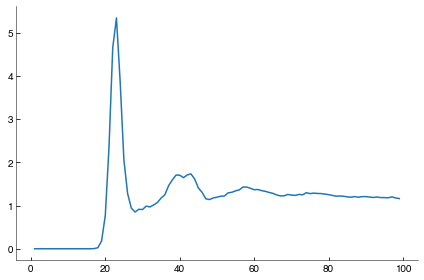

In [329]:
centres.get_gr()
plt.plot(centres.gr['r'],centres.gr['g']);

Similarly, we can compute the coordination within a larger cutoff, for example around the first minimum of `g(r)`.

In [109]:
rcut = 27
neighs=centre_tree.query_ball_tree(centre_tree,rcut)
coordination = [len(n)-1 for n in neighs]

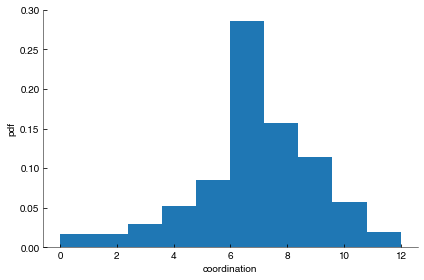

In [110]:
plt.hist(coordination, density=True); plt.xlabel('coordination');plt.ylabel('pdf');

In [111]:
centre_contacts_weights = []
num_contacts = []
for c in centre_contacts:
    w = []
    if len(c)>0:
        w=list(contacts.volume[c])
    
    num_contacts.append(len(c))
    centre_contacts_weights.append(w)

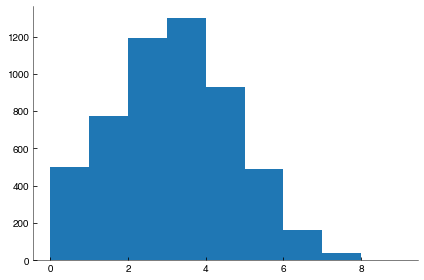

In [112]:
plt.hist(num_contacts,bins=np.arange(10));

## Network construction

We need to find common contacts to construct edges.

In [113]:
from scipy.spatial.distance import cdist

In [158]:
rcut = centres.radius.mean()*1.6
neighs = contact_tree.query_ball_tree(centre_tree,rcut)
closest = []
closest_dists = []
for i,n in enumerate(neighs):
    n = np.array(n)
#     print(i,n
    if len(n)>0:
        dists = np.linalg.norm(centres.coord[n]-contacts.coord[i], axis=1) 
#         print(n,dists,dists.argsort())
        order = dists.argsort()[:2]
        closest.append(n[order])
        closest_dists.append(dists[order])
    else:
        closest.append([])
        closest_dists.append([])

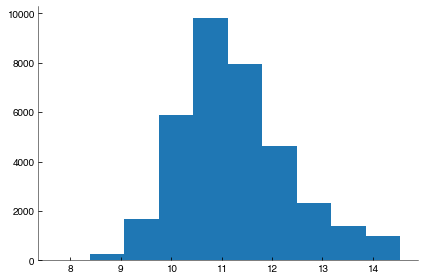

In [159]:
# check the distribution of distances between contacts and centres
dists = np.concatenate(np.array([d for d in closest_dists if len(d)>0]))
plt.hist(dists);

In [160]:
missing = [1 for n in closest if len(n)==0]
sum(missing)

0

In [161]:
import networkx as nx

peak 137.0625
mean 114.1870162433228
std 53.1959160143887


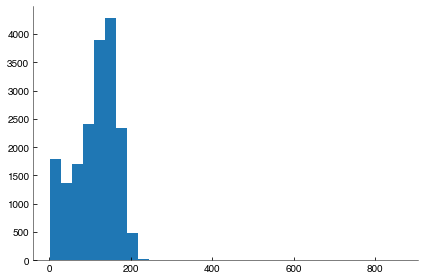

In [184]:
plt.hist(contacts.volume,bins=32);
H, e = np.histogram(contacts.volume,bins=32)
print('peak',e[:-1][H.argmax()])
print('mean', np.mean(contacts.volume))
print('std', np.std(contacts.volume))

In [189]:
G = nx.Graph()
min_vol = 137+53 #very important threshold: it decides how many edges form the network. Thousands of edges quickly become unmanegeable from the plotting point of view
for i,e in enumerate(closest):
    if contacts.volume[i]>min_vol: 
        if len(e)>1:
            G.add_edge(e[0],e[1])#,weight=contacts.volume[i])#, weight=contacts.volume[i])
G.number_of_edges()

543

In [190]:
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
N = len( np.concatenate([list(g) for g in Gcc]))
with open('giant.xyz', 'w') as fw:
    fw.write(f'{N}\nParticles\n')
    for u,d in enumerate(list(Gcc)):
        ids = np.array(list(d))
        transparency = cont
        for i,ID in enumerate(ids):
            p = centres.coord[ID]
            r = centres.radius[ID]
            fw.write(f'Type_{u} {p[0]} {p[1]} {p[2]} {r}\n')
        

In [170]:
pos = nx.spring_layout(G)

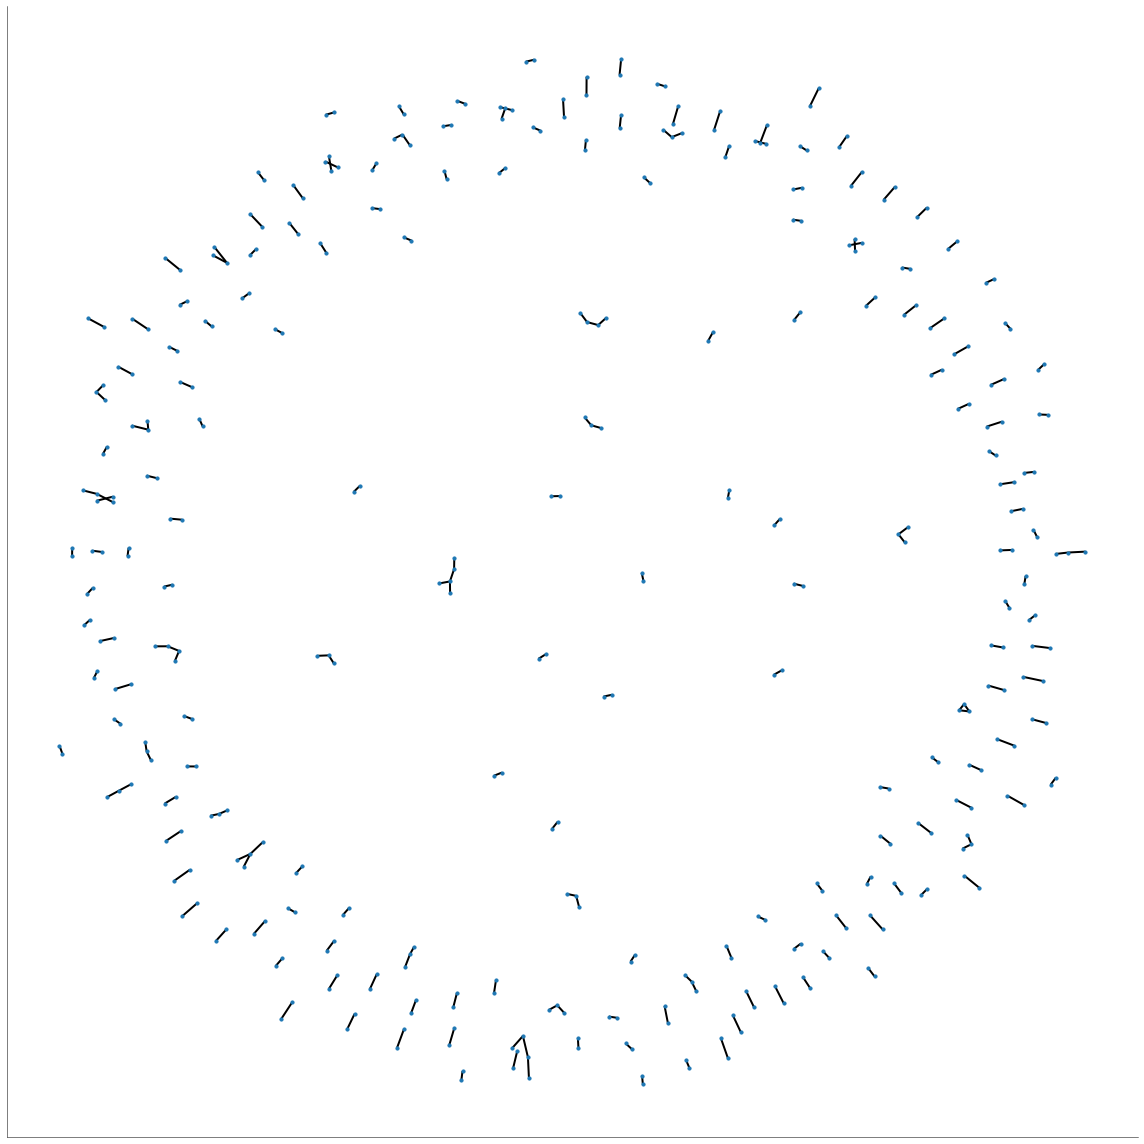

In [171]:
plt.figure(figsize=(16,16))
nx.draw_networkx(G, pos,node_size=10,with_labels=False,width=2)
# plt.xlim(-0.25,0.25)
# plt.ylim(-0.1,0.2)
plt.savefig(f"figs/{G.number_of_edges()}edges.png", dpi=300)

From the Graph we can extract many possible metrics. For example the **deegre assortativity** measures to what extent nodes with similar degrees cluster together (see Newman PRE 67, 026126 􏰒2003􏰀).

In [24]:
nx.degree_assortativity_coefficient(G)

0.1522152874853166

One can compute the **centrality**, which should simply reflect the total number fo contacts

In [25]:
centrality = nx.degree_centrality(G)

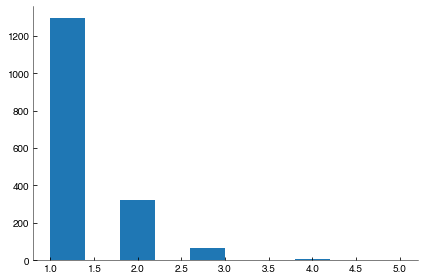

In [26]:
plt.hist(np.array(list(centrality.values()))*G.number_of_nodes());

Simple geometrical measures are also possible, such as the **number of triangles**.

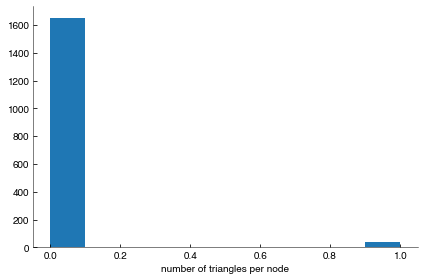

In [27]:
plt.hist(nx.triangles(G).values());
plt.xlabel("number of triangles per node");

We can for example compute the **transitivity** $T$ as
$$T=3 \frac{\# \text { triangles }}{\# \text { triads }}$$
which is $T=1$ for complete graphs (where every pair of nodes is connected by a single edge).

In [28]:
nx.transitivity(G)

0.06405693950177936

![figs/transitivity.png](figs/transitivity.png)

# Stress Tensor

The stress data from Jun are stored in a different sub-folder

In [299]:
ls data/stressTensor/

0.8/ 1.2/ 2.0/


In [300]:
ls data/stressTensor/1.2/

coordstress..ovito  major_stress.txt    stress_tensor.pkl
coordstress.xyz     minor_stress.txt    stress_trace.txt


The stress data are easily read into the `centres` object

In [336]:
centres.get_stress_info(f'data/stressTensor/{pol}/', rcut=28)

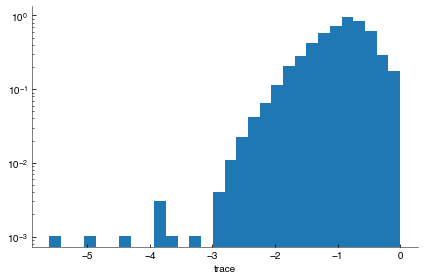

In [302]:
plt.hist(centres.trace,bins=30, density=True);
plt.yscale('log')
plt.xlabel('trace');

The  minor stress is the most negative one as we are following the tension-positive convention of Peteres _et al_ PRE 2005

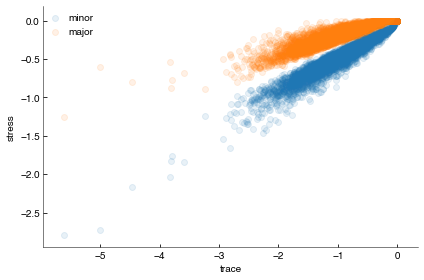

In [303]:
plt.scatter(trace,minor, alpha=0.1, label='minor')
plt.scatter(trace,major, alpha=0.1, label = 'major')
plt.xlabel('trace')
plt.ylabel('stress');
plt.legend();

Compute a weighted g(r) 

In [333]:
centres.get_gr(rmax=100,dr=1.)
# select a threshold
def compare_g(threshold):
    mgr = centres.get_masked_gr(centres.trace, threshold)
    plt.plot(centres.gr['r'],centres.gr['g'])
    plt.plot(mgr['r'],mgr['g'])
    
interact(compare_g,threshold=widgets.FloatSlider(min=-3, max=0, value=-1,continuous_update=False))

interactive(children=(FloatSlider(value=-1.0, continuous_update=False, description='threshold', max=0.0, min=-…

<function __main__.compare_g(threshold)>

In [254]:
interact(centres.plot_clusters,threshold=widgets.FloatSlider(min=-3, max=0, value=-1,continuous_update=False), rcut=fixed(28),size=fixed(5.0));


interactive(children=(FloatSlider(value=-1.0, continuous_update=False, description='threshold', max=0.0, min=-…

In [78]:
centres.pearsonr_coordination_z_slice(200,centres.local_aniso, plot=False)

200 0.2358400710475771


0.2358400710475771

In [96]:
zs = np.arange(100,380,10)
profiles = centres.all_pearson_profiles(zs)
print (profiles.keys())

dict_keys(['z', 'trace_profile', 'aniso_profile', 'major_profile', 'minor_profile'])


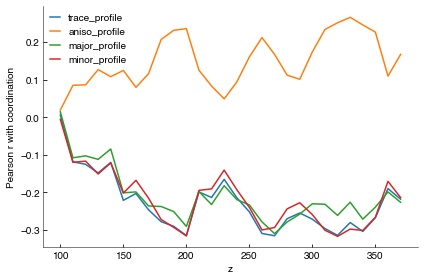

In [98]:
for k,v in profiles.items():
    if 'profile' in k:
        plt.plot(zs,v,label=k)
plt.legend()
plt.xlabel('z'),plt.ylabel('Pearson r with coordination');
plt.savefig('figs/profile_ correlations.png')

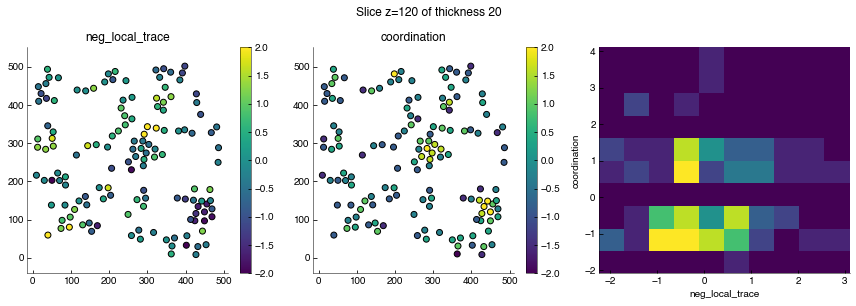

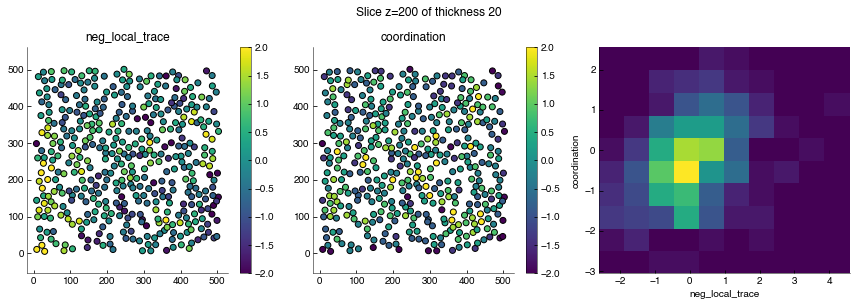

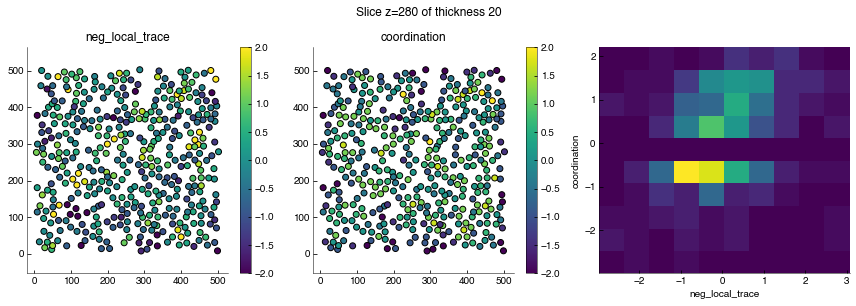

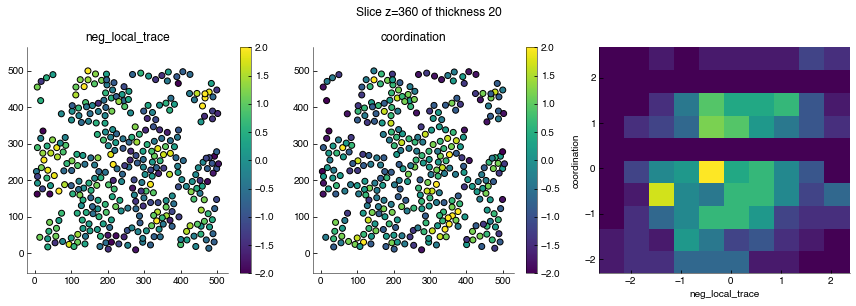

In [394]:
for z in [120,200,280,360]:
    centres.plot_sample_slices(z,-centres.local_trace,centres.stress_coordination, feature_scaling=True, thickness=20)
